# **导入和配置模块**

In [ ]:
import tensorflow as tf

In [ ]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

# **下载图像并选择风格图像和内容图像：**

In [ ]:
#content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
content_path = tf.keras.utils.get_file('content.jpg','https://rayhaber.com/wp-content/uploads/2020/07/marilyn-monroe-kimdir.jpg')
style_path = tf.keras.utils.get_file('style.jpg','http://1.bp.blogspot.com/-PCR0Rd0Og2g/TevI2kTluUI/AAAAAAAAE10/y24OkyjM-4s/s1600/1%2Bstuart%2Bdavis%252C%2Bpad%2Bno.%2B4.jpg')


131072/121909 [================================] - 0s 1us/step


# **将输入可视化**

In [ ]:
def load_img(path_to_img):
  max_dim = 512 
  # 加载图像的函数，并将其最大尺寸限制为 512 像素
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img


In [ ]:
#创建一个简单的函数显示图像
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

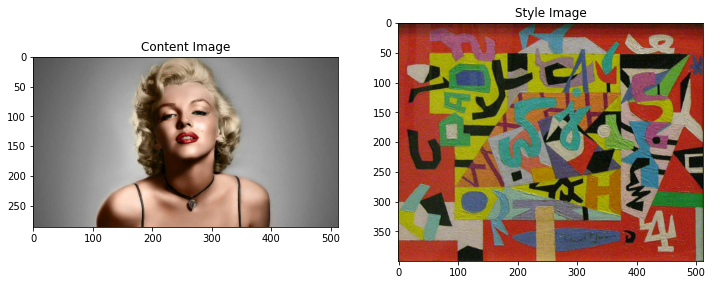

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

# 使用 TF-Hub **进行快速风格迁移**

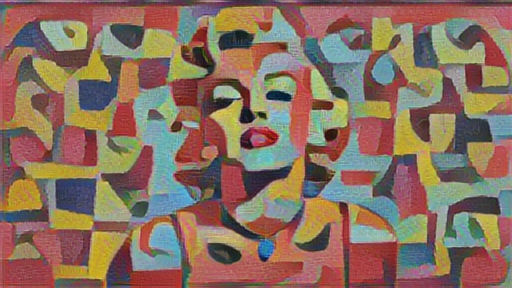

In [ ]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

# **定义内容和风格的表示**

**VGG19 网络结构**
对于一个输入图像，我们尝试匹配这些中间层的相应风格和内容目标的表示

In [ ]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574726144/574710816 [==============================] - 4s 0us/step


TensorShape([1, 1000])

In [ ]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

49152/35363 [=========================================] - 0s 0us/step


[('maillot', 0.20582585),
 ('miniskirt', 0.14980148),
 ('brassiere', 0.12755689),
 ('wig', 0.11708047),
 ('maillot', 0.047346715)]

In [ ]:
#现在，加载没有分类部分的 VGG19 ，并列出各层的名称：
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80150528/80134624 [==============================] - 1s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
#从网络中选择中间层的输出以表示图像的风格和内容：
#这也是卷积神经网络能够很好地推广的一个原因：它们能够捕获不变性并定义类别（例如猫与狗）之间的 feature (特征)，这些 feature (特征)与背景噪声和其他干扰无关。

content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

# **建立模型**

**以下函数构建了一个 VGG19模型，该模型返回一个中间层输出的列表**

In [ ]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet') #利用Keras的功能接口提取中间层的值
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names] 

  model = tf.keras.Model([vgg.input], outputs). # 在使用功能接口定义模型时，我们需要指定输入和输出.model = Model(inputs, outputs)
  return model 

**然后建立模型：**

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 400, 512, 64)
  min:  0.0
  max:  658.3956
  mean:  32.03177

block2_conv1
  shape:  (1, 200, 256, 128)
  min:  0.0
  max:  3989.643
  mean:  157.88475

block3_conv1
  shape:  (1, 100, 128, 256)
  min:  0.0
  max:  6567.9224
  mean:  186.21294

block4_conv1
  shape:  (1, 50, 64, 512)
  min:  0.0
  max:  16584.52
  mean:  682.75226

block5_conv1
  shape:  (1, 25, 32, 512)
  min:  0.0
  max:  2716.9773
  mean:  51.05798



# **风格计算**

In [ ]:
#图像的内容由中间 feature maps (特征图)的值表示
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

# **提取风格和内容**

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

# **在图像上调用此模型，可以返回 style_layers 的 gram 矩阵（风格）和 content_layers 的内容：**

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.016057618
    max:  16381.289
    mean:  184.94446

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  32192.08
    mean:  6245.8125

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  162877.94
    mean:  7015.1846

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  1270816.9
    mean:  114818.23

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  176758.77
    mean:  1475.5184

Contents:
   block5_conv2
    shape:  (1, 17, 32, 512)
    min:  0.0
    max:  1337.2611
    mean:  11.286002


# **梯度下降**

In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [ ]:
#定义一个 tf.Variable 来表示要优化的图像
image = tf.Variable(content_image)

In [ ]:
#这是一个浮点图像，因此我们定义一个函数来保持像素值在 0 和 1 之间
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
#创建一个 optimizer 
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [ ]:
#为了优化它，我们使用两个损失的加权组合来获得总损失：
style_weight=1e-2
content_weight=1e4

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [ ]:
#使用 tf.GradientTape 来更新图像。
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

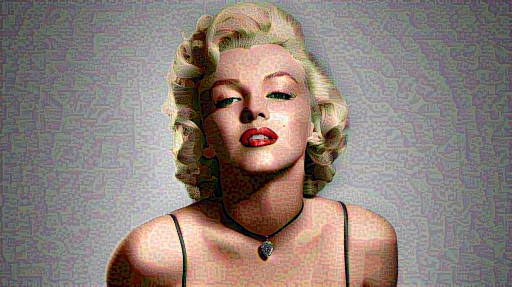

In [ ]:
#测试
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

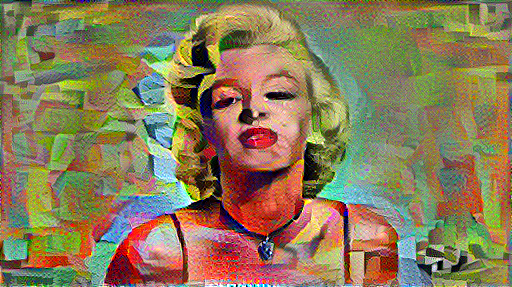

Train step: 1000
Total time: 3856.9


In [ ]:
#进行优化
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

# **总变分损失**
通过正则化图像的高频分量来减少这些高频误差

In [ ]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

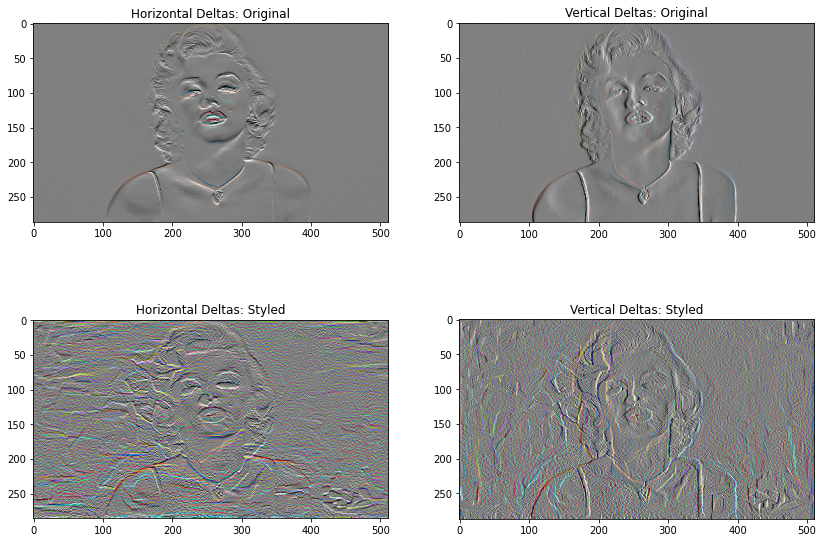

In [ ]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

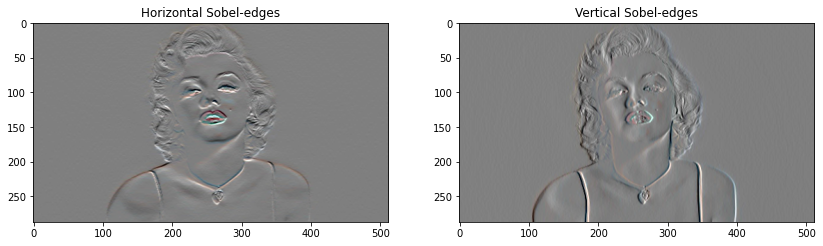

In [ ]:
#高频分量是一个边缘检测器
plt.figure(figsize=(14,10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[...,1]/4+0.5), "Vertical Sobel-edges")

In [ ]:
#与此相关的正则化损失是这些值的平方和：
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [ ]:
total_variation_loss(image).numpy()

82255.66

In [ ]:
tf.image.total_variation(image).numpy()

array([82255.66], dtype=float32)

# **重新进行优化**

In [ ]:
total_variation_weight=30

In [ ]:
#加入 train_step 函数中
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [ ]:
#重新初始化优化的变量：
image = tf.Variable(content_image)

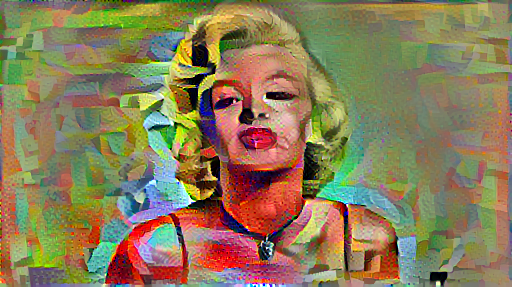

Train step: 1000
Total time: 3891.7


In [ ]:
#并进行优化：
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))